In [1]:
rm(list=ls())
library(scran)
library(scds)
library(scDblFinder)
library(Seurat)
library(Matrix)
library(cowplot) 
library(gridExtra)
library(dplyr)
library(clustree)
library(DT)
library(pheatmap)
library(RColorBrewer)
library(gplots)
library(pracma)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
   

In [2]:
PATH <- "CLS1-100-4"
data_dir <- paste0("/mnt/isilonX200/scRNA/Project_1/GRCh38_20200320/", PATH, "/outs/filtered_feature_bc_matrix/")
LABEL <- "CLS1-D4"

In [3]:
data <- Read10X(data.dir = data_dir)
colnames(data) <- paste(colnames(data), LABEL, sep = "-")
sc.data <- CreateSeuratObject(counts = data, project = "Project_1", min.cells = 0)

In [4]:
# Using scran - doubletCells
mat <- sc.data@assays$RNA
mat <- as.matrix(mat[1:nrow(mat),1:ncol(mat)])
dbl.dens <- doubletCells(mat)

In [5]:
# cxds
sce <- as.SingleCellExperiment(sc.data)
sce = cxds(sce,retRes = TRUE)
sce = bcds(sce,retRes = TRUE,verb=TRUE)
sce = cxds_bcds_hybrid(sce)

-> selecting genes


-> simulating doublets


-> training classifier


-> done.





Clustering cells...

Identifying top genes per cluster...

Creating ~10000 artifical doublets...

Finding KNN...

Evaluating cell neighborhoods...

Finding threshold...

Threshold found:0.969



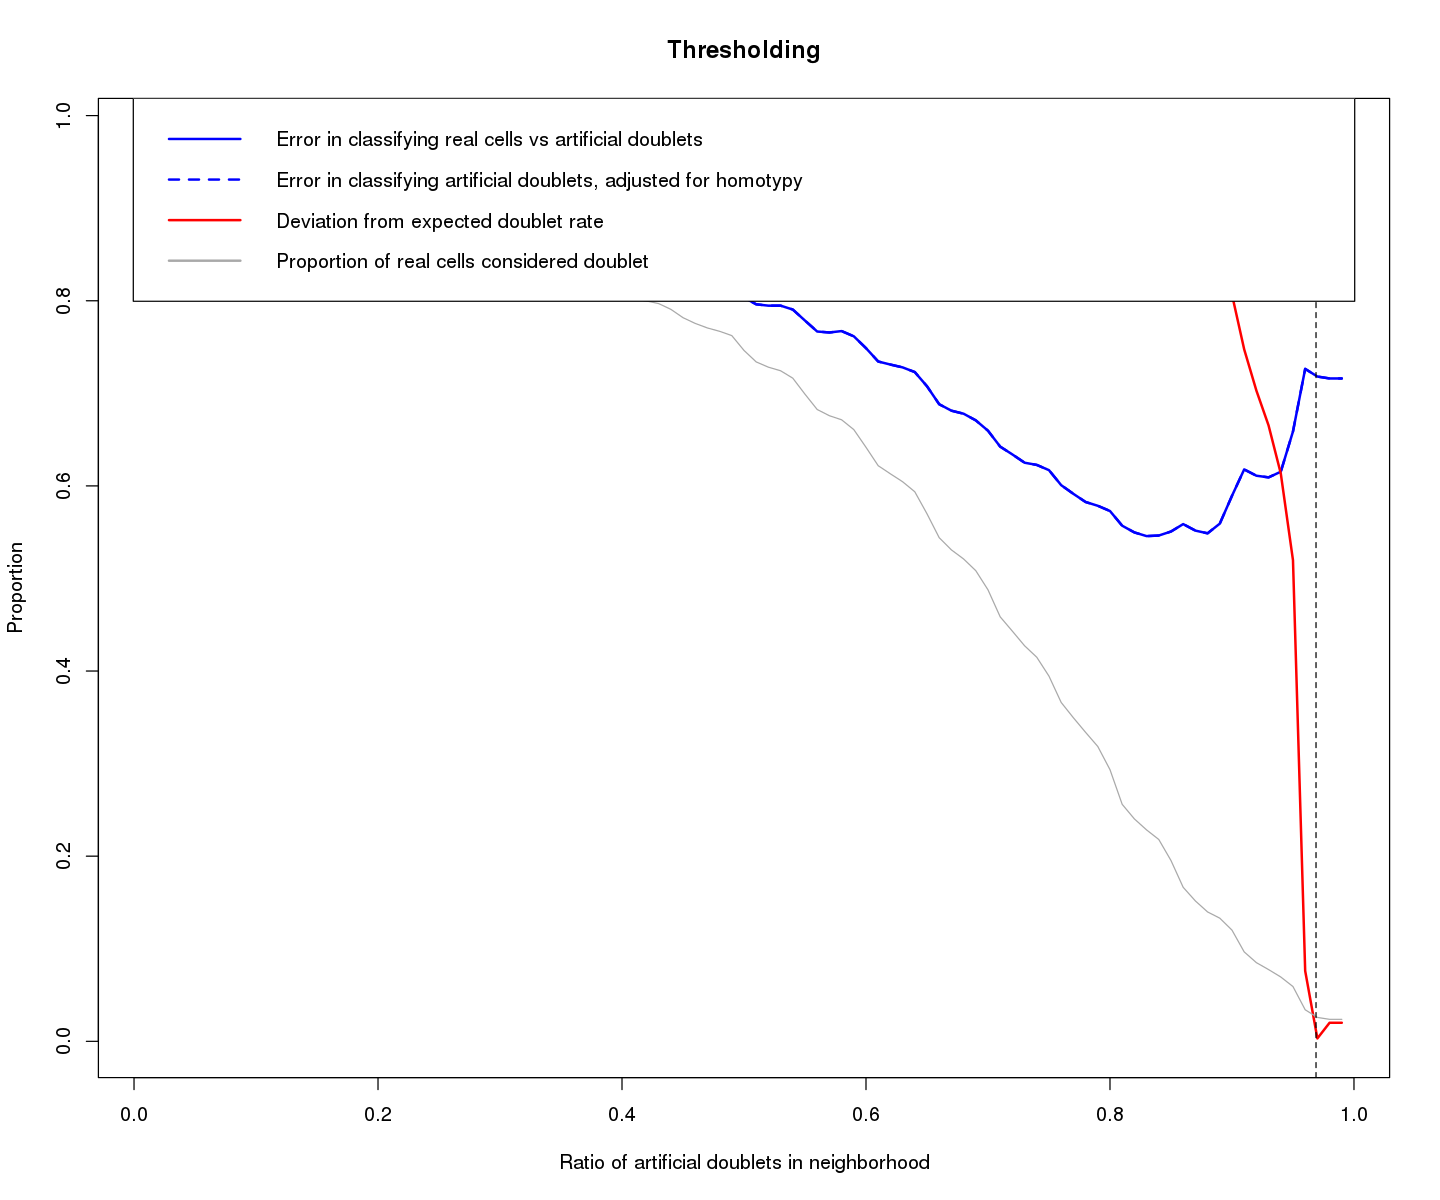

In [6]:
# scDblFinder (mimicing doubletFinder)
options(repr.plot.width=12, repr.plot.height=10)
sce <- scDblFinder(sce, dbr = 0.03, artificialDoublets = 10000)

In [7]:
sc.data[["doubletCells"]] <- dbl.dens
sc.data[["cxds"]] <- sce$cxds_score
sc.data[["bcds"]] <- sce$bcds_score
sc.data[["hybrid"]] <- sce$hybrid_score
sc.data[["scDblFinder"]] <- sce$scDblFinder.score
sc.data[["doublets"]] <- sce$scDblFinder.class

In [8]:
doublets_count <- nrow(subset(sc.data[[]], doublets=="doublet"))
singlets_count <- nrow(subset(sc.data[[]], doublets=="singlet"))
print(paste0("Doublets: ", doublets_count, " ( ", signif(doublets_count/(doublets_count+singlets_count)*100), "% )"))
print(paste0("singlets: ", singlets_count, " ( ", signif(singlets_count/(doublets_count+singlets_count)*100), "% )"))

[1] "Doublets: 101 ( 2.60914% )"
[1] "singlets: 3770 ( 97.3909% )"


In [9]:
#Save Rds
CLS1D4.doublet <- sc.data@meta.data
save(CLS1D4.doublet, file = '/mnt/isilonX200/scRNA/Project_1/Result/CLS1D4.doublet.Rdata')

In [10]:
sc.data@meta.data$condition <- LABEL
sc.data[["percent.MT"]] <- PercentageFeatureSet(sc.data, pattern = "^MT-",assay = "RNA")

Warning message:
"Using shapes for an ordinal variable is not advised"
Warning message:
"Removed 17 rows containing missing values (geom_point)."


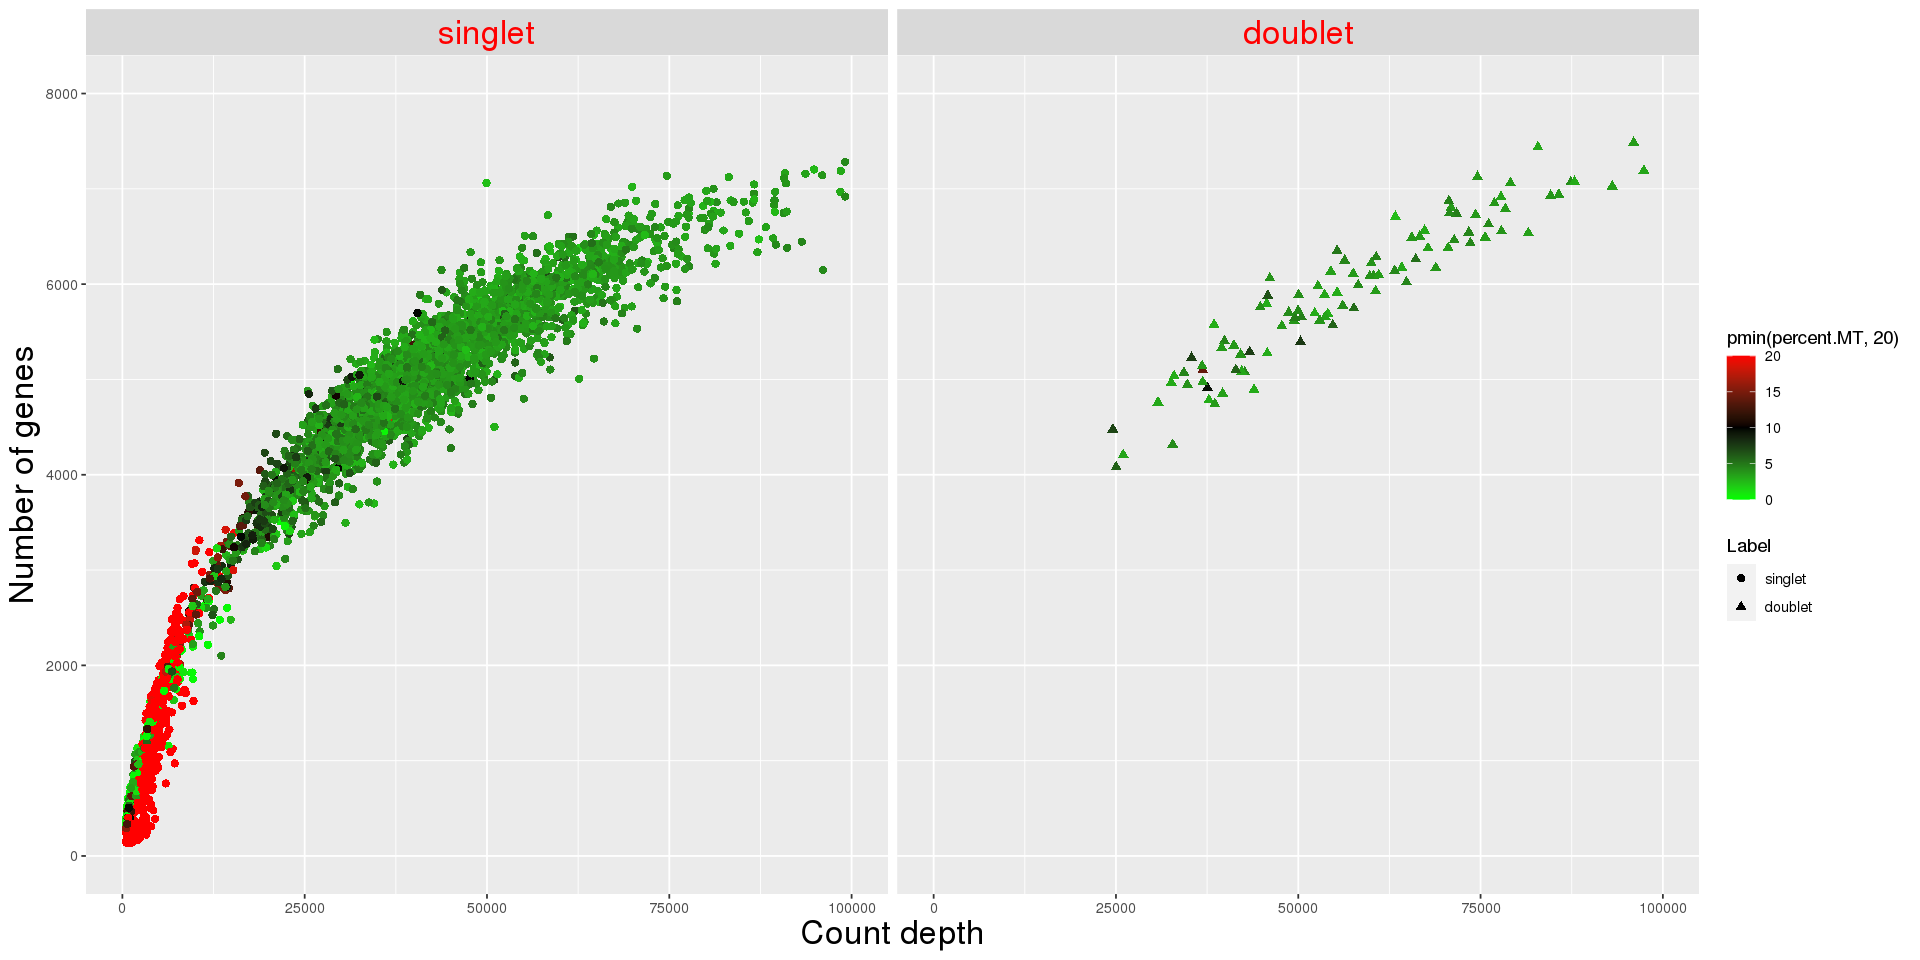

In [11]:
options(repr.plot.width=16, repr.plot.height=8)
Label <- factor(sc.data@meta.data$doublets, ordered = TRUE, levels = c('singlet', 'doublet'))
ggplot(data.frame(sc.data@meta.data, Label = Label), aes(x = nCount_RNA, y = nFeature_RNA, color = pmin(percent.MT, 20), shape = Label)) +
       theme(axis.title = element_text(size = 20), strip.text.x = element_text(size = 20, color = "red")) +
       xlim(0, 100000) + 
       ylim(0, 8000) +
       scale_color_gradient2(low="green", mid = 'black', high="red", midpoint = 10)+ 
       geom_point(size = 2) + 
       labs(x = "Count depth", y = "Number of genes", size = 6) + 
       facet_grid(. ~ Label)

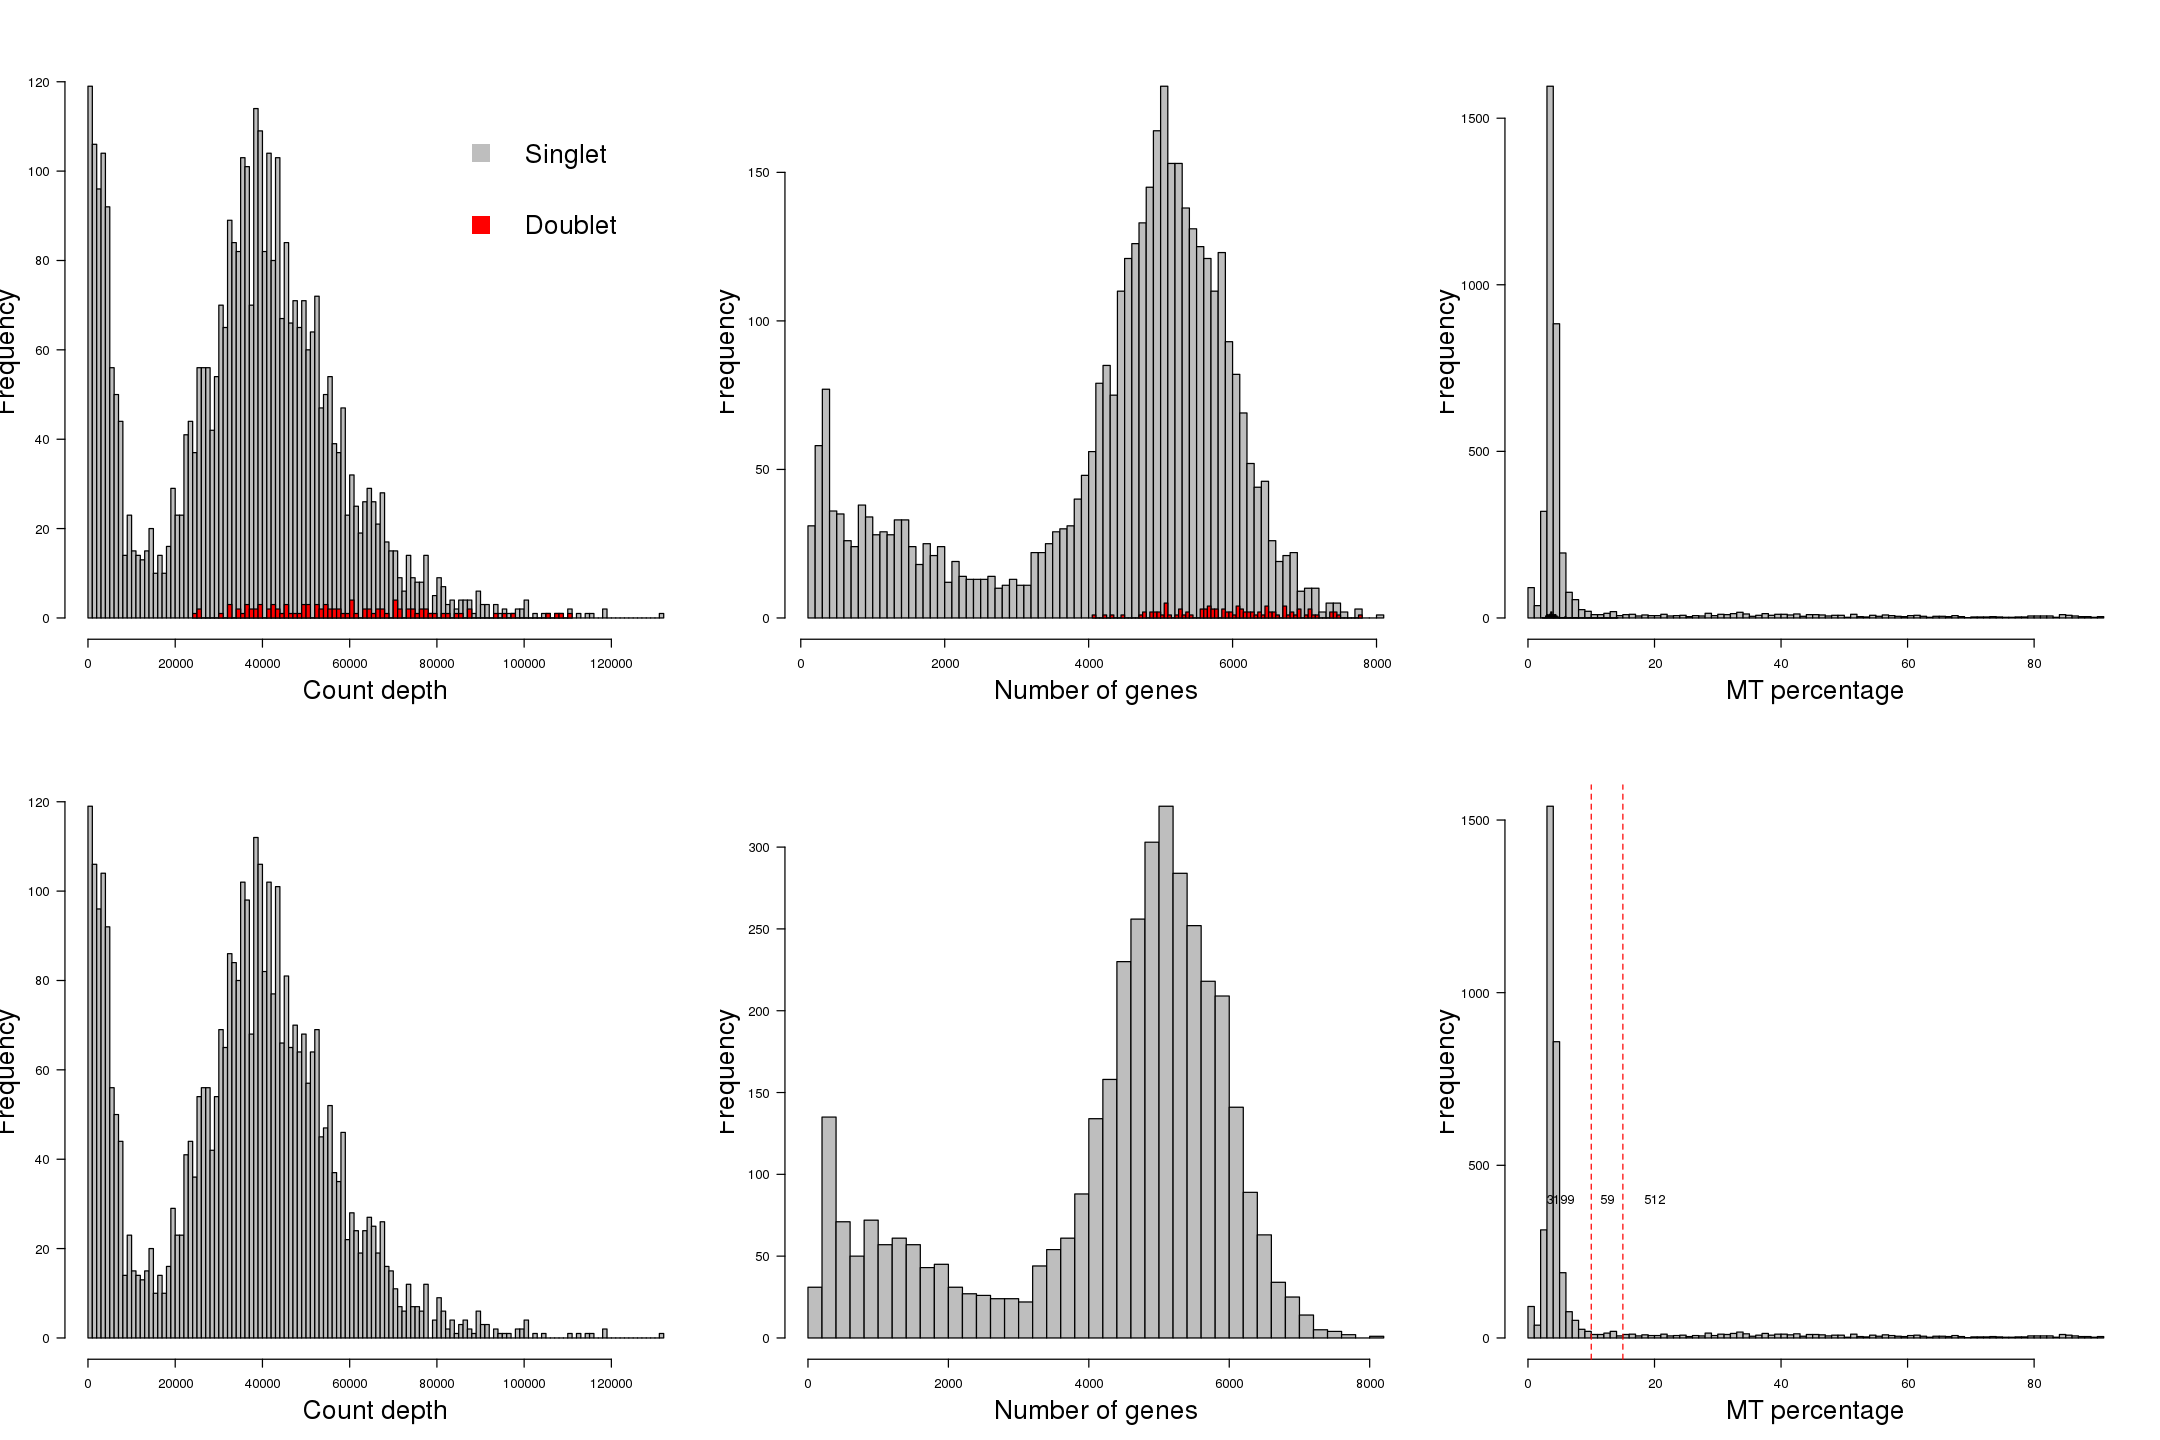

In [12]:
options(repr.plot.width=18, repr.plot.height=12)
par(mfrow = c(2, 3), las=1)
hist(sc.data$nCount_RNA, 100, main = '', xlab = 'Count depth', col = 'gray', cex.lab=2)
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'nCount_RNA'], 100, col = 'red', add = TRUE)
legend(70000, 120, pch = 15, col = c('gray', 'red'), c('Singlet', 'Doublet'), cex = 2, pt.cex = 3, bty = "n" , x.intersp=0.5)

hist(sc.data$nFeature_RNA, 100, main = '', xlab = 'Number of genes', col = 'gray', cex.lab=2)
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'nFeature_RNA'], 100, col = 'red', add = TRUE)

hist(sc.data$percent.MT, 100, main = '', xlab = 'MT percentage', col = 'gray', cex.lab=2)
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'percent.MT'], 50, col = 'red', add = TRUE)

hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'nCount_RNA'], 100, main = '', xlab = 'Count depth', col = 'gray', cex.lab=2)
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'nFeature_RNA'], 50, main = '', xlab = 'Number of genes', col = 'gray', cex.lab=2)
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'], 100, main = '', xlab = 'MT percentage', col = 'gray', cex.lab=2)
abline(v = c(10, 15), col = 'red', lty = 2)
text(c(5, 12.5, 20), 400,
     table((sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'] >= 10) + 
          (sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'] >= 15)))

In [13]:
output <- subset(sc.data, subset = doublets == 'singlet')
output <- subset(output, subset = percent.MT <= 10)

In [14]:
output@assays$logCPM <- (NormalizeData(object = output, verbose = FALSE)@assays$RNA)

In [15]:
output@meta.data <- output@meta.data[, c('orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'percent.MT')]
CLS1D4 <- output
saveRDS(CLS1D4, file = '/mnt/isilonX200/scRNA/Project_1/Result/CLS1D4.qc.Rds')